# Item importance evaluation
This notebook aims to find out the importance of each item in our dataset, so based on the infos we (might) find out, we may direct our efforts to an especific model...

In [49]:
import numpy as np
import pandas as pd
from utils import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import sys
import xgboost as xgb
import lightgbm as lgb
from datetime import datetime
from catboost import CatBoost, CatBoostRegressor, Pool, cv
plt.rcParams['figure.figsize'] = (45, 10.0) # set default size of plots

NUMBER_OF_LAGS = 4

sys.path.append("../../main/datasets/")
!ls  ../../main/datasets/

1.0v.zip


In [50]:
infos, items, orders = read_data("../../main/datasets/")
print("Sanity checks...", infos.shape, items.shape, orders.shape)

Sanity checks... (10463, 3) (10463, 8) (2181955, 5)


## Preparing our dataset

In [51]:
# Changing our time signatures, 
# adding our promotion feature 
# and aggregating our data by weeks...
process_time(orders)

In [52]:
df = dataset_builder(orders, items)

## Calculating the relevance: Enhanced approach
We might also try to guesstimate the relevance of items based in **how many weeks a given item is sold**. The main idea behind this approach is to try to eliminate the items that are sold just a few times, but due to its' price, have a high effect on the relevance. So, products that happen to be sold fewer times, will be linearly penalized.

In [53]:
shifting = df.copy()

shifting['soldUntilThisWeek'] = 0
shifting.loc[df.orderSum > 0, 'soldUntilThisWeek'] = 1

group_item_sold = shifting.groupby(['group_backwards', 'itemID']).agg({'soldUntilThisWeek':'sum'})

# Taking infos from the past to the present date with shifting...
# We'll .shift(-1) because it sorts our "group_backwards", 
# so doing .shift(1) would cause a HUGE dataleak.
test = group_item_sold.groupby('itemID')[['soldUntilThisWeek']].shift(-1)
test.sort_values(['itemID', 'group_backwards'], ascending=[True, False], inplace=True)
test.reset_index(inplace=True)
aux = pd.DataFrame()
for i in range(13, 0, -1):
    accum = test.loc[test.group_backwards >= i].groupby(['itemID'], as_index=False).agg({'soldUntilThisWeek':'sum'})
    accum['group_backwards'] = i
    accum['soldUntilThisWeek'] = accum['soldUntilThisWeek'] / (13 - i)
    aux = pd.concat([aux, accum])
    
aux.reset_index(0, drop=True, inplace=True)

new_feature = pd.merge(df, aux, left_on=['group_backwards', 'itemID'], right_on=['group_backwards', 'itemID'])
new_feature['itemRelevance'] = new_feature['recommendedRetailPrice'] * new_feature['soldUntilThisWeek']

In [47]:
plotting = new_feature.loc[new_feature.group_backwards == 1][['itemID', 'recommendedRetailPrice',
                                                   'soldUntilThisWeek', 'itemRelevance']].sort_values(by=['itemRelevance'], ascending=False)

In [48]:
plotting

,itemID,recommendedRetailPrice,soldUntilThisWeek,itemRelevance
126335,780,5306.70,0.333333,1768.900
134309,8754,2902.50,0.583333,1693.125
126428,873,3088.97,0.500000,1544.485
134339,8784,2849.00,0.500000,1424.500
135615,10060,4189.50,0.333333,1396.500
...,...,...,...,...
129728,4173,8.75,0.000000,0.000
134806,9251,214.27,0.000000,0.000
134805,9250,133.31,0.000000,0.000
134804,9249,106.14,0.000000,0.000


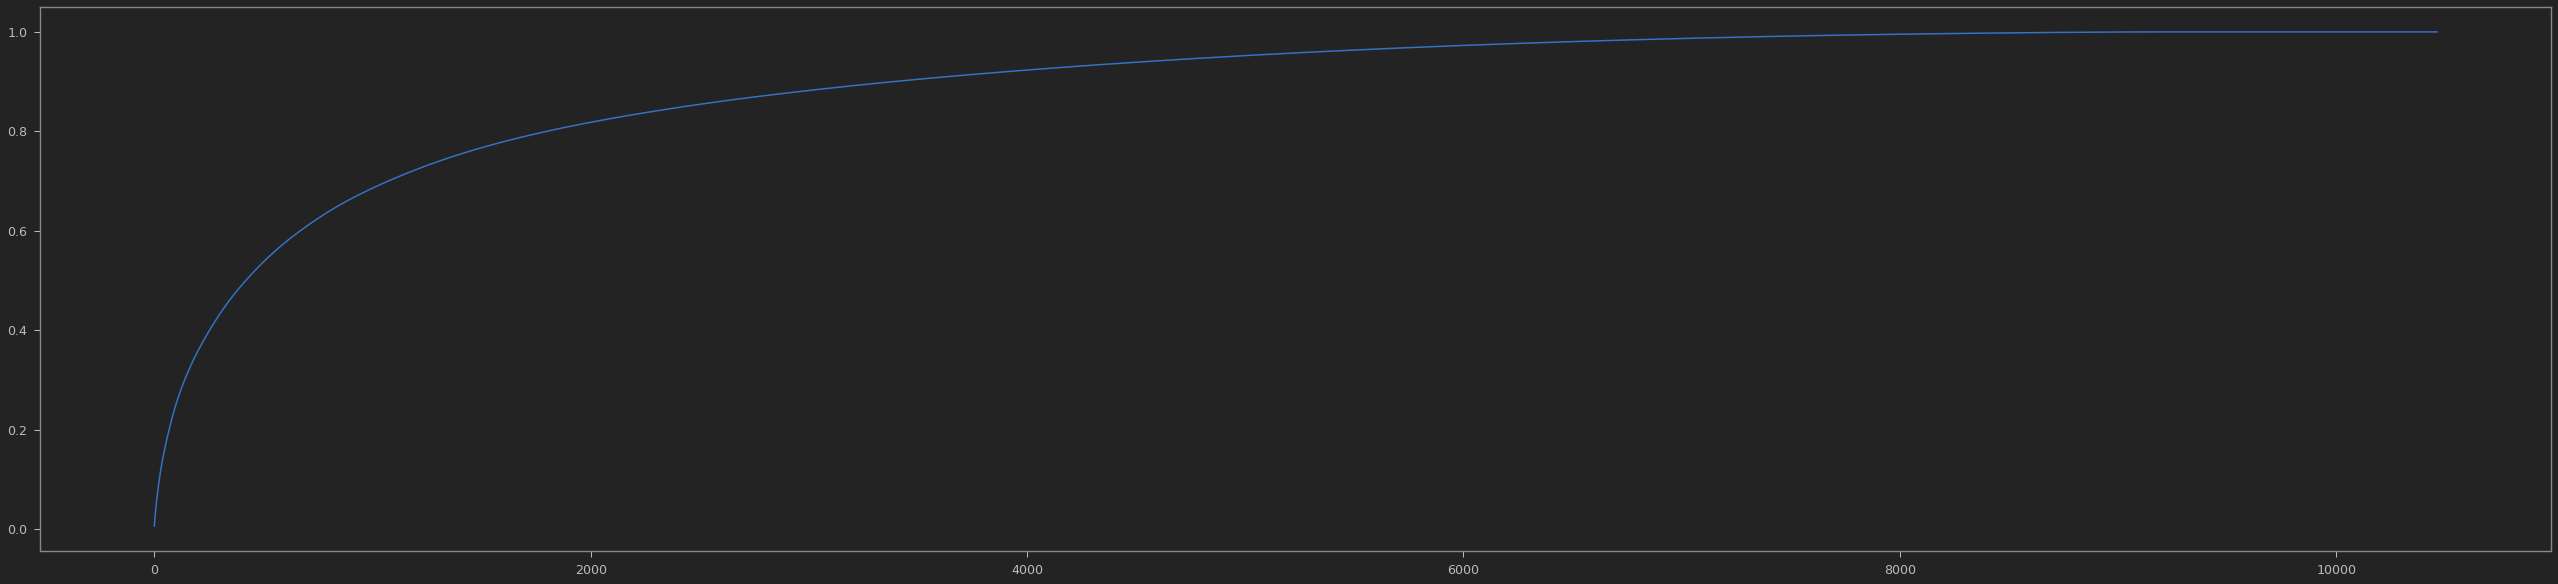

In [34]:
relevance_values = (plotting['itemRelevance'] / plotting['itemRelevance'].sum(
)).sort_values(ascending=False, ignore_index=True).cumsum()
plt.plot(relevance_values)